# MAP-Elites track generations

In [1]:
import numpy as np
import requests
import json
import random
from ribs.archives import GridArchive
from ribs.emitters import EmitterBase
from ribs.schedulers import Scheduler
from ribs.visualize import grid_archive_heatmap
import matplotlib.pyplot as plt


import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Server JS which exposes the trackGenerations and genetic operators 
BASE_URL = 'http://localhost:4242'
POINTS_COUNT = 50
MAX_SELECTED_CELLS = 10
SOLUTION_DIM = POINTS_COUNT * 2 + MAX_SELECTED_CELLS * 2 + 1 
TRACK_SIZE_RANGE = (2, 5)
LENGTH_RANGE = (400, 2000)
ITERATIONS = 5;
ARCHIVE_DIM = 2;
INIT_POPULATION = ARCHIVE_DIM * ARCHIVE_DIM 


# debug flags
DEBUG_CROSSOVER = True
DEBUG_MUTATION = True

### Helper functions

In [3]:
def generate_solution(iteration):
    response = requests.post(f'{BASE_URL}/generate', json={
        "id": iteration + random.random(),
        "mode": "voronoi",
        "trackSize": random.randint(TRACK_SIZE_RANGE[0], TRACK_SIZE_RANGE[1])
    })
    response.raise_for_status()
    return response.json()
    
def solution_to_array(solution):
    array = np.zeros(SOLUTION_DIM)
    # Fill in dataSet
    for i, point in enumerate(solution["dataSet"]):
        array[i*2] = point["x"]
        array[i*2 + 1] = point["y"]
    # Fill in selectedCells
    for i, cell in enumerate(solution["selectedCells"]):
        if i < MAX_SELECTED_CELLS:
            array[POINTS_COUNT*2 + i*2] = cell["x"]
            array[POINTS_COUNT*2 + i*2 + 1] = cell["y"]
    array[-1] = solution["id"]
    return array

def array_to_solution(array):
    dataSet = [{"x": float(array[i]), "y": float(array[i+1])} for i in range(0, POINTS_COUNT*2, 2)]
    selectedCells = [{"x": float(array[i]), "y": float(array[i+1])} 
                     for i in range(POINTS_COUNT*2, SOLUTION_DIM-1, 2) 
                     if array[i] != 0 or array[i+1] != 0]
    
    return {
        "id": float(array[-1]),
        "mode": "voronoi",
        "dataSet": dataSet,
        "selectedCells": selectedCells
    }

def get_fractional_part(id_value):
    return id_value - int(id_value)

def evaluate_solution(solution):
    try:
        response = requests.post(f'{BASE_URL}/evaluate', json=solution)
        response.raise_for_status()
        result = response.json()
        fitness = result['fitness']
        objective = -(fitness['deltaX'] + fitness['deltaY'])
        print("len(solution selected ")
        print(len(solution['selectedCells']))
        measures = [len(solution['selectedCells']), fitness['length']]
        return objective, measures
    except requests.RequestException as e:
        print(f"Error in evaluate_solution: {e}")
        return -np.inf, [TRACK_SIZE_RANGE[0], LENGTH_RANGE[0]]

## Genetic operators

In [4]:
class CustomEmitter(EmitterBase):
    def __init__(self, archive, solution_dim, batch_size=ARCHIVE_DIM, bounds=None):
        super().__init__(archive, solution_dim=solution_dim, bounds=bounds)
        self.batch_size = batch_size
        self.iteration = 0

    def ask(self):
        self.iteration += 1
        if self.iteration <= INIT_POPULATION: 
            return np.array([solution_to_array(generate_solution(self.iteration-1)) for _ in range(self.batch_size)])
        elif np.random.random() < 0.5:  # Mutation
            return self.mutate_solutions()
        else:  # Crossover
            return self.crossover_solutions()

    def generate_initial_solutions(self):
        return np.array([solution_to_array(generate_solution(self.iteration-1)) for _ in range(self.batch_size)])


    def mutate_solutions(self):
        parents_data = self.archive.sample_elites(self.batch_size)
        mutated = []

        for i in range(self.batch_size):
            solution = parents_data['solution'][i]
            parent_dict = array_to_solution(solution)

            response = requests.post(f'{BASE_URL}/mutate', json={
                "individual": parent_dict,
                "intensityMutation": 10
            })
            response.raise_for_status()
            mutated_dict = response.json()['mutated']
            
            # Keep the same ID for mutations, just update the iteration part
            parent_frac = get_fractional_part(parent_dict['id'])
            mutated_dict['id'] = self.iteration - 1 + parent_frac
            
            mutated.append(solution_to_array(mutated_dict))

        return np.array(mutated)

    def crossover_solutions(self):
        offspring = []
        for i in range(self.batch_size // 2):
            parents = self.archive.sample_elites(2)
            
            parent1 = array_to_solution(parents['solution'][0])
            parent2 = array_to_solution(parents['solution'][1])
            
            response = requests.post(f'{BASE_URL}/crossover', json={
                "mode": "voronoi",
                "parent1": parent1,
                "parent2": parent2
            })
            response.raise_for_status()
            children = response.json()['offspring']
            print("children selected ") 
            print(len(children['sel']))
            # Create a new ID based on parents' IDs
            parent1_frac = get_fractional_part(parent1['id'])
            parent2_frac = get_fractional_part(parent2['id'])
            child_frac = (parent1_frac + parent2_frac) % 1  # Ensure it's between 0 and 1
            new_id = self.iteration - 1 + child_frac
            
            child = {
                "id": new_id,
                "mode": "voronoi",
                "trackSize": len(children['sel']),
                "dataSet": children['ds'],
                "selectedCells": children['sel']
            }
            
            offspring.append(solution_to_array(child))
            if DEBUG_CROSSOVER:
                logger.info(f"Crossover {i+1}, Child: Parent1 ID {parent1['id']}, Parent2 ID {parent2['id']}, Child ID {new_id}")
        
        return np.array(offspring)

## Illuminating search spaces by mapping elites


In [5]:
def run_map_elites(iterations):
    archive = GridArchive(solution_dim=SOLUTION_DIM,
                          dims=[ARCHIVE_DIM, ARCHIVE_DIM],
                          ranges=[TRACK_SIZE_RANGE, LENGTH_RANGE])

    emitter = CustomEmitter(archive,
                            solution_dim=SOLUTION_DIM,
                            batch_size=INIT_POPULATION,
                            bounds=[(0, 600)] * (SOLUTION_DIM - 1) + [(0, float('inf'))])

    scheduler = Scheduler(archive, [emitter])

    for itr in range(iterations):
        try:
            solution_batch = scheduler.ask()
            
            objectives = []
            measures_list = []
            updated_solutions = []

            for solution_array in solution_batch:
                solution = array_to_solution(solution_array)
                objective, measures = evaluate_solution(solution)
                
                if not np.isfinite(objective):
                    logger.warning(f"Non-finite objective value: {objective}. Skipping this solution.")
                    continue
                
                objectives.append(objective)
                measures_list.append(measures)

            if objectives and measures_list:
                print(f"Before tell: Archive size = {len(archive)}")
                scheduler.tell(objectives, measures_list)
                print(f"After tell: Archive size = {len(archive)}")
                print(f"Objectives: {objectives}")
                print(f"Measures: {measures_list}")
            else:
                logger.warning(f"Iteration {itr + 1}: No valid solutions to add to archive")

            logger.info(f"> {itr + 1} iterations completed")
            logger.info(f"  - Archive size: {len(archive)}")
            logger.info(f"  - Archive coverage: {archive.stats.coverage}")
            
        except Exception as e:
            logger.error(f"Error in iteration {itr}: {str(e)}")
            raise

    return archive

In [6]:
final_archive = run_map_elites(ITERATIONS)

len(solution selected 
4
len(solution selected 
5
len(solution selected 
4
len(solution selected 
3
Before tell: Archive size = 0


INFO:__main__:> 1 iterations completed
INFO:__main__:  - Archive size: 2
INFO:__main__:  - Archive coverage: 0.5


After tell: Archive size = 2
Objectives: [-3.320526, 0.3316500000000002, -1.097363, -1.60067]
Measures: [[4, 957.621033], [5, 1193.875732], [4, 914.160217], [3, 806.411377]]
len(solution selected 
2
len(solution selected 
5
len(solution selected 
5


INFO:__main__:> 2 iterations completed
INFO:__main__:  - Archive size: 2
INFO:__main__:  - Archive coverage: 0.5


len(solution selected 
5
Before tell: Archive size = 2
After tell: Archive size = 2
Objectives: [-2.909012, 4.078102, -1.2757109999999998, -0.06613800000000003]
Measures: [[2, 587.956055], [5, 1190.925659], [5, 940.399597], [5, 908.618469]]
len(solution selected 
5
len(solution selected 
4
len(solution selected 
2


INFO:__main__:> 3 iterations completed
INFO:__main__:  - Archive size: 3
INFO:__main__:  - Archive coverage: 0.75


len(solution selected 
2
Before tell: Archive size = 2
After tell: Archive size = 3
Objectives: [-0.11718700000000004, -1.523835, -0.208222, -0.25721700000000003]
Measures: [[5, 893.743225], [4, 1283.815186], [2, 740.508728], [2, 718.138611]]
len(solution selected 
5
len(solution selected 
5
len(solution selected 
4


INFO:__main__:> 4 iterations completed
INFO:__main__:  - Archive size: 3
INFO:__main__:  - Archive coverage: 0.75


len(solution selected 
3
Before tell: Archive size = 3
After tell: Archive size = 3
Objectives: [-3.811477, -5.523809, -5.02565, -2.826034]
Measures: [[5, 1025.866333], [5, 1407.092896], [4, 1316.671997], [3, 1172.4198]]
len(solution selected 
2
len(solution selected 
5
len(solution selected 
2


INFO:__main__:> 5 iterations completed
INFO:__main__:  - Archive size: 3
INFO:__main__:  - Archive coverage: 0.75


len(solution selected 
4
Before tell: Archive size = 3
After tell: Archive size = 3
Objectives: [-1.4572939999999999, -0.5554580000000002, -0.4506039999999999, -1.696717]
Measures: [[2, 745.67157], [5, 1184.64624], [2, 753.233582], [4, 1269.371338]]


## Visualize Results

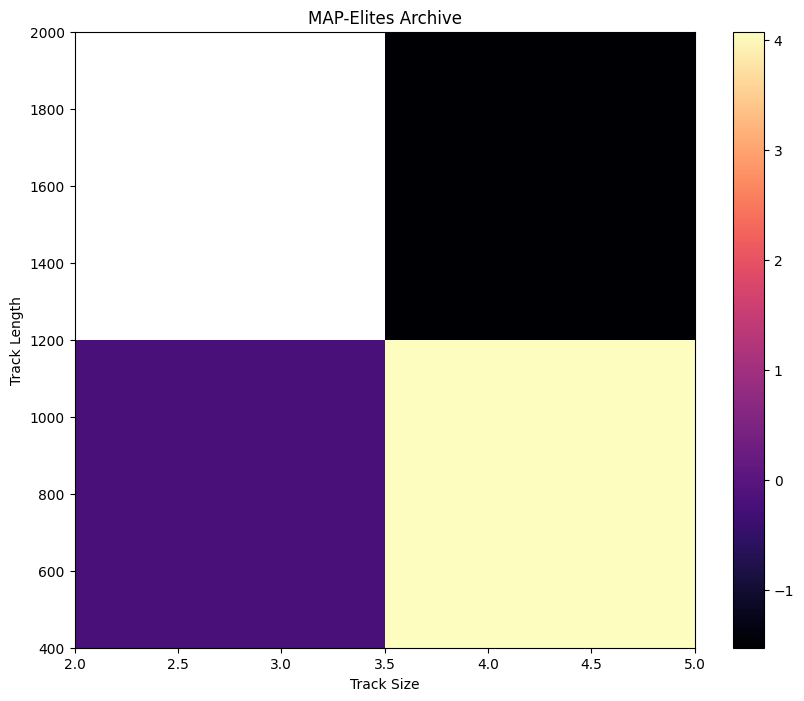

In [7]:
plt.figure(figsize=(10, 8))
grid_archive_heatmap(final_archive)
plt.title("MAP-Elites Archive")
plt.xlabel("Track Size")
plt.ylabel("Track Length")
plt.show()